# CoCliCo --- Orléans Notebook Demonstration (March 2022)

Coastal Climate Core Services is an European effort to develop an opean web-platform to aid decision making on coastal risk (2021 - 2025). Please have a look at our website to find out more about the project: https://coclicoservices.eu/

During this project several datasets will be made available, which can be explored on the platform as well as accessed via cloud-storage buckets. In this notebook, some examples are provided on how to interact with the data using Python. 

- Notebook author: Floris Calkoen & Etiënne Kras, 12 May 2022
- Notebook update: Etiënne Kras, 16 Sep 2022

## Requirements

The  following Python libraries are required: 

- zarr 
- xarray
- gcsfs

Additional use of the following libraries is recommended: 

- Dask
- GeoPandas
- Rioxarray

These libraries have several dependencies, including: 
- Numpy
- Matplotlib
- Pandas
- gdal (C library)

## JRC Wave Energy Flux dataset

The data is hosted in cloud buckets, mostly in zarr format. [Zarr](https://zarr.readthedocs.io/en/stable) is a format for storage of chunked, compressed, N-dimensional arrays. 

Here, we use the JRC Wave Energy Flux dataset as an example of how to work with Zarr datasets. The dataset [Mentaschi et al. 2017] (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL072488) describes global changes of extreme coastal wave energy fluxes for the RCP8.5 scenario.

## (OPTIONAL): Install required packages (require for Google Colab)

Running the following cell will install required packages. If this notebook is run on a local environment it is recommended to create an isolated environment. Zarr is required to work with zarr format data, xarray to read the data into Python,  gcsfs to work with data stored on Google cloud buckets and ipytree to show the directory tree ofthe zarr store.

In [2]:
!pip install zarr -q  
!pip install xarray[complete] -q
!pip install gcsfs -q
!pip install ipytree -q

## Imports

In [1]:
# Xarray is a Python library to work with labelled multi-dimensional arrays. The 
# library is able to directly load data from an url. 

import zarr 
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Printing the dataset object shows the storm surge level consists of three dimensions. 
# Every storm surge level is associated with a certain station, scenario and revisting period. 
ds = xr.open_zarr("gs://dgds-data-public/coclico/global_wave_energy_flux.zarr")
ds

<xarray.Dataset>
Dimensions:  (stations: 4828, rp: 8, time: 11)
Coordinates:
    lat      (stations) float64 dask.array<chunksize=(4828,), meta=np.ndarray>
    lon      (stations) float64 dask.array<chunksize=(4828,), meta=np.ndarray>
  * rp       (rp) float32 5.0 10.0 20.0 50.0 100.0 200.0 500.0 1e+03
  * time     (time) float32 1.995e+03 2.01e+03 2.02e+03 ... 2.09e+03 2.1e+03
Dimensions without coordinates: stations
Data variables:
    wef      (stations, rp, time) float64 dask.array<chunksize=(2414, 4, 6), meta=np.ndarray>
Attributes: (12/13)
    Conventions:      CF-1.8
    End_date:         30-Nov-2099 21:00:00
    Institution:      Joint European Research Center, Directorate for Space, ...
    Project_Acronym:  CoastAlRisk
    Project_Name:     Prototype of a first Global Integrated Coastal Impact-b...
    Starting_date:    01-Dec-2009
    ...               ...
    disclaimer:       Unless the following would not be permitted or valid un...
    email:            lorenzo.mentaschi@ec.europa.eu
    reference:        Mentaschi L., Vousdoukas M., Voukouvalas E., Dosio A., ...
    terms_for_use:    European Union, 1995-2015.\nReuse is authorised, provid...
    title:            Global Wave Energy Flux
    version:          1.0

## Preparing a plot example

Here we replicate one of the plots from the paper. 

In [8]:
# time (x-axis) will be same for all scenario's
time = ds["time"].values

In [9]:
# function to extract ssl values at certain station for certain scenario
f_wef_values = (
    lambda station, rp: ds.isel(stations=station)
    .sel(rp=rp)["wef"]
    .values
)

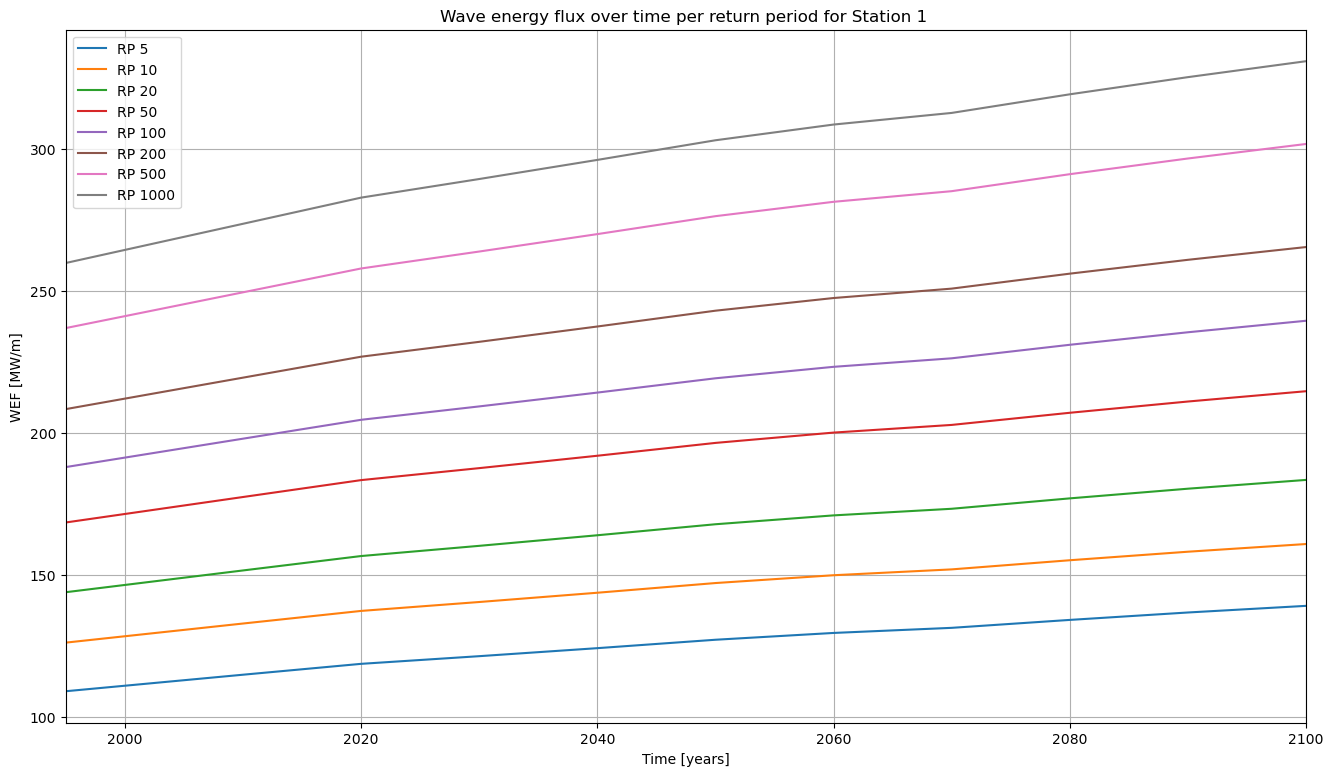

In [40]:
# Here the function defined in the previous cell is used to extract wave energy 
# fluxes for station x. Matplotlib is used to generate a figure and axes object. 
# The matplotlib axes object (ax) contains a method to add data to the axis. This 
# method is used to add the data for all eight different return periods, hence, 
# the f_wef_values function is used eight times in the loop 

station = 1 # select station 

fig, ax = plt.subplots(figsize=(16,9))
for i in ds["rp"]:
    ax.plot(time, f_wef_values(station=station, rp=i)/1000, label="RP %s"%int(i.values))
ax.set_xlabel("Time [years]")
ax.set_ylabel("WEF [MW/m]")
ax.set_title("Wave energy flux over time per return period for Station %s "%station)
plt.grid()
plt.xlim(time[0], time[-1])
plt.legend();

## Some additional info for working with Zarr data 

Instead of directly using xarray we here load the data with the zarr library to 
explain some of its aspects and features

In [31]:
# Like with xarray, the data can be read directly from an url. 
zarr_store = zarr.open("gs://dgds-data-public/coclico/global_wave_energy_flux.zarr")

In [32]:
# The zarr store object, contains an attribute with describes the structure of the store. 
zarr_store.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.FSStore
No. members,5
No. arrays,5
No. groups,0
Arrays,"lat, lon, rp, time, wef"


In [33]:
# The directory tree can also be printed... 
print(zarr_store.tree())

/
 ├── lat (4828,) float64
 ├── lon (4828,) float64
 ├── rp (8,) float32
 ├── time (11,) float32
 └── wef (4828, 8, 11) float64


In [34]:
# The zarr store can also be inspected per group
zarr_store["wef"].info

Name,/wef
Type,zarr.core.Array
Data type,float64
Shape,"(4828, 8, 11)"
Chunk shape,"(2414, 4, 6)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,3398912 (3.2M)
No. bytes stored,3116154 (3.0M)



## Important notes on Zarr from Xarray perspective

Please note: 

1. Zarr can only read/write Zarr groups, but no individual zarr arrays.
2. Zarr arrays do not have dimensions names like NetCDF. Therefore, each Zarr array requires a special array attribute `_ARRAY_DIMENSIONS`. Without this attribute, data cannot be load from zarr into xarray. 

For an extensive discussion see [this entry of the xarray documentation](https://xarray.pydata.org/en/stable/internals/zarr-encoding-spec.html)

The attributes from a certain array can be listed like:

In [41]:
dict(zarr_store["wef"].attrs)

{'_ARRAY_DIMENSIONS': ['stations', 'rp', 'time'],
 'add_offset': 1.0,
 'coordinates': 'lat lon',
 'long_name': 'Wave Energy Flux',
 'scale_factor': 1.0,
 'units': 'W/m'}